In [47]:
import numpy as np
#pip install pysindy
import pysindy as psd
from data_loader import data_loader_noH
import numpy as np
import matplotlib.pyplot as plt
from utils import params

In [48]:
x_train, dx_train, x_val, dx_val = data_loader_noH()

In [49]:
library = psd.PolynomialLibrary(degree=2)
model = psd.SINDy(optimizer=psd.STLSQ(threshold=0.01), feature_library=library)

In [50]:
model.fit(x_train, t = 1, x_dot=dx_train)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'],
      optimizer=STLSQ(threshold=0.01))

In [51]:
# model.print()

In [52]:
theta = np.array(library.transform(x_val))
sindy_coeff = np.transpose(model.coefficients())
dx_predict = np.matmul(theta, sindy_coeff)

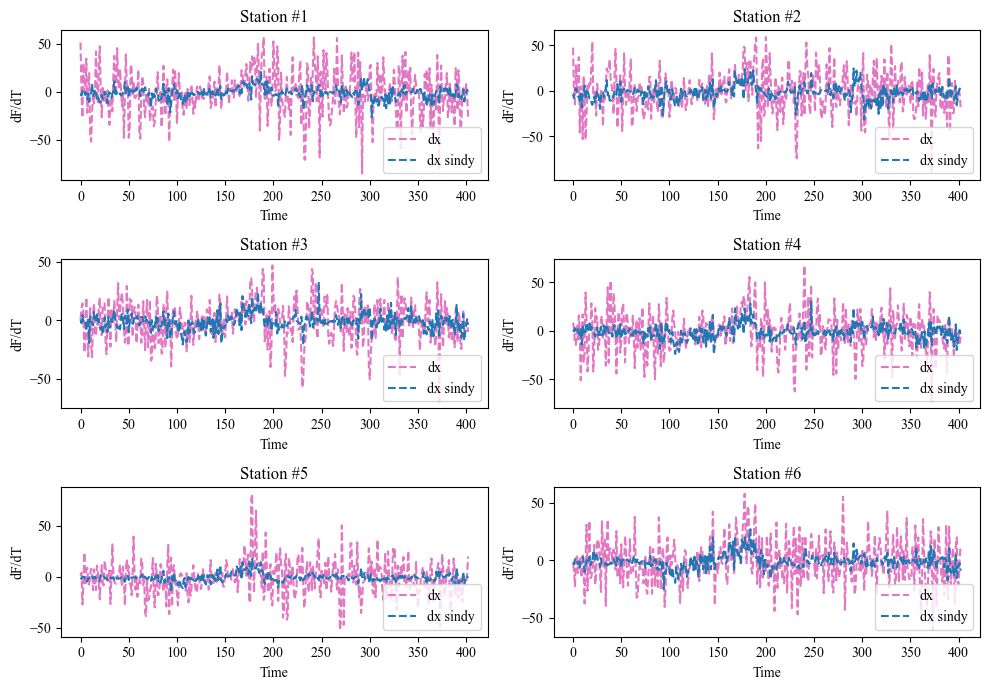

In [53]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))

# Plot each column in a separate subplot
for row in range(3):
    for col in range(2):
        #axs[row, col].plot(dx_ori[:, row*2 + col], label = 'dx')
        axs[row, col].plot(100*dx_val[:, row*2 + col], "--", color = '#e377c2', label = 'dx')
        axs[row, col].plot(100*dx_predict[:, row*2 + col], "--", color = '#1f77b4' ,label = 'dx sindy')
        axs[row, col].set_title(f'Station #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('dF/dT')
        axs[row, col].legend(loc='lower right', fontsize='medium')

# Show the figure
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/dz_dzSINDy_Plot.png", dpi=300)

In [54]:
from sindy_utils import sindy_library
sim_result_1 = np.zeros(x_val.shape)
sim_result_2 = np.zeros(x_val.shape)

In [55]:
for t in range(x_val.shape[0]):
    x_init = x_val[t,:].reshape(1,-1)
    Theta_curr = np.array(library.transform(x_init))
    dx_curr = np.matmul(Theta_curr, sindy_coeff)
    x_new = x_init + dx_curr
    sim_result_1[t,:] = x_new

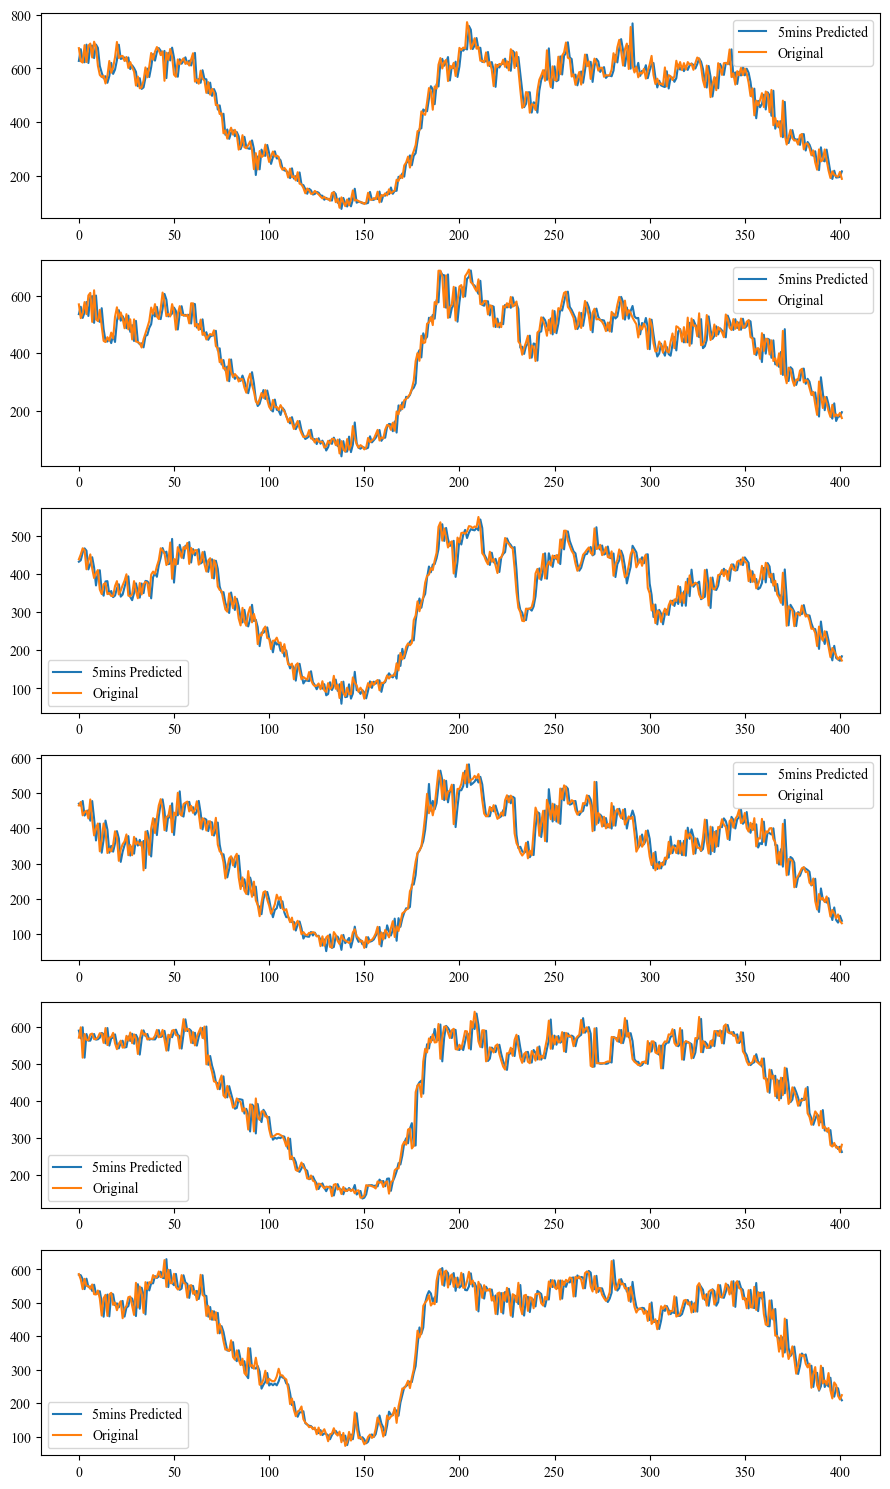

In [56]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(9, 15))
for i in range(6):
    axs[i].plot(100*sim_result_1[:-1, i], label = '5mins Predicted')
    axs[i].plot(100*x_val[1:,i], label = 'Original')
    axs[i].legend()
plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error as mse

In [58]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_1[:-1, i], 100*x_val[1:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [66]:
import pandas as pd
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/Sindy.csv")

In [45]:
import random
indices = range(6)
index_pair = []
for i in range(6):
    for j in range(i+1, 6):
        index_pair.append((indices[i], indices[j]))
random.seed(100)
index_pair = random.sample(index_pair, 6)

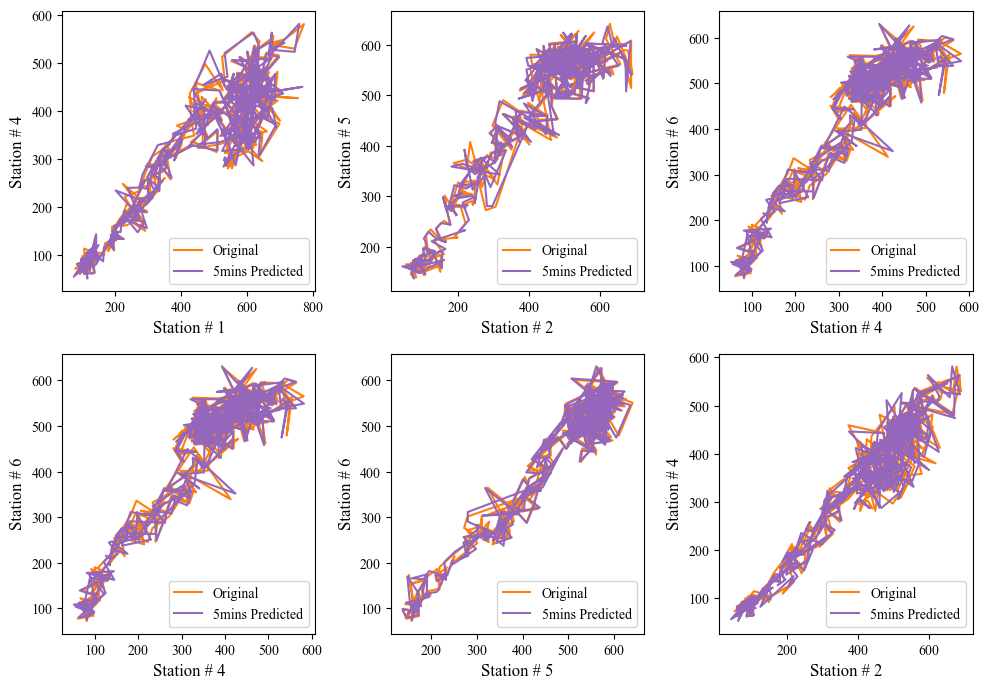

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
for row in range(2):
    for col in range(3):
        index1 = index_pair[row*2 + col][0]
        index2 = index_pair[row*2 + col][1]
        axs[row, col].plot(100 * x_val[:-1,index1], 100 * x_val[:-1,index2], color = '#ff7f0e', label = 'Original')
        axs[row, col].plot(100 * sim_result_1[1:,index1], 100 * sim_result_1[1:,index2], color = '#9467bd', label = '5mins Predicted')
        #axs[row, col].plot(100 * X_ori[1:,index1], 100 * X_ori[1:,index2], "--", label = '5mins Predicted')
        axs[row, col].legend(loc='lower right', fontsize='medium')
        axs[row, col].set_xlabel(f'Station # {index1 + 1}', fontsize = 12)
        axs[row, col].set_ylabel(f'Station # {index2 + 1}', fontsize = 12)
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/predicted_and_z_phase.png", dpi = 300)